# Feedback Prize - Evaluating Student Writing

## Analyze argumentative writing elements from students grade 6-12


Automatically segment texts and classify argumentative and rhetorical elements in essays written by 6th-12th grade students. 

## Data Description

The dataset contains argumentative essays written by U.S students in grades 6-12. The essays were annotated by expert raters for elements commonly found in argumentative writing.

Task is to predict the human annotations. You will first need to segment each essay into discrete rhetorical and argumentative elements (i.e., discourse elements) and then classify each element as one of the following:

- Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- Position - an opinion or conclusion on the main question
- Claim - a claim that supports the position
- Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
- Rebuttal - a claim that refutes a counterclaim
- Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
- Concluding Statement - a concluding statement that restates the claims

train.csv - a .csv file containing the annotated version of all essays in the training set
- id - ID code for essay response
- discourse_id - ID code for discourse element
- discourse_start - character position where discourse element begins in the essay response
- discourse_end - character position where discourse element ends in the essay response
- discourse_text - text of discourse element
- discourse_type - classification of discourse element
- discourse_type_num - enumerated class label of discourse element
- predictionstring - the word indices of the training sample, as required for predictions

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('csv'):
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import gc
import random

from IPython import display as ipd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import tensorflow as tf
from tensorflow import keras

import spacy
from spacy import displacy

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

/kaggle/input/feedback-prize-2021/sample_submission.csv
/kaggle/input/feedback-prize-2021/train.csv


In [2]:
TRAIN_PATH = '../input/feedback-prize-2021/train/'
TEST_PATH = '../input/feedback-prize-2021/test/'

submission = pd.read_csv('/kaggle/input/feedback-prize-2021/sample_submission.csv')
train = pd.read_csv('/kaggle/input/feedback-prize-2021/train.csv')
## add text file names
train["file_path"] = train["id"].apply(lambda identifier: "../input/feedback-prize-2021/train/" + identifier + ".txt")

train['discourse_id'] = train['discourse_id'].astype(int)
train['discourse_start'] = train['discourse_start'].astype(int)
train['discourse_end'] = train['discourse_end'].astype(int)
train["discourse_len"] = train["discourse_end"] - train["discourse_start"]

train.head(2)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,file_path,discourse_len
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,../input/feedback-prize-2021/train/423A1CA112E...,221
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,../input/feedback-prize-2021/train/423A1CA112E...,82


## Distributions

<AxesSubplot:xlabel='discourse_end', ylabel='Count'>

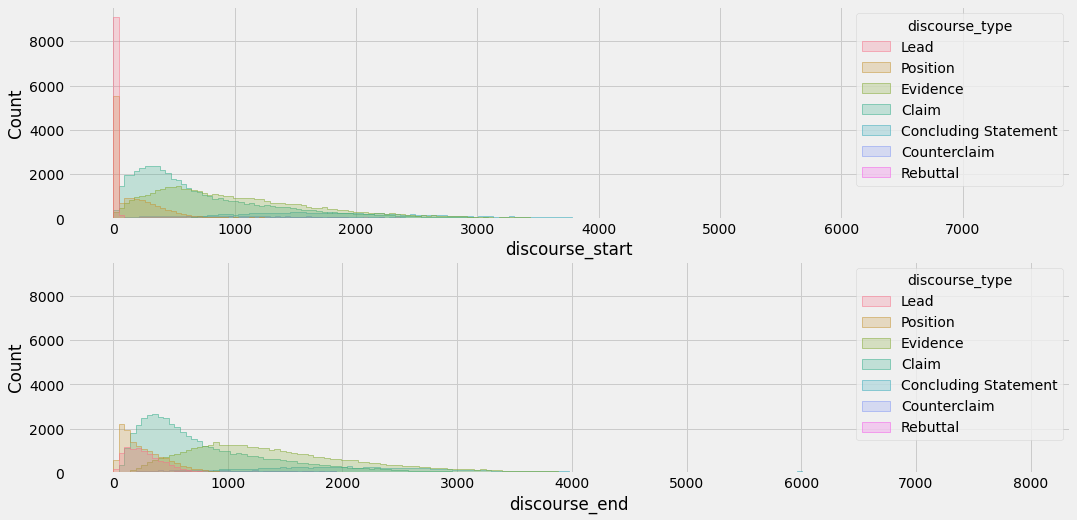

In [3]:
## distribution of discourse_start and discourse_end by discorse_type

f, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(16, 8), sharey=True)
sns.histplot( train, x='discourse_start', ax=ax1, hue="discourse_type", element="step")
sns.histplot( train, x='discourse_end', ax=ax2, hue="discourse_type", element="step")

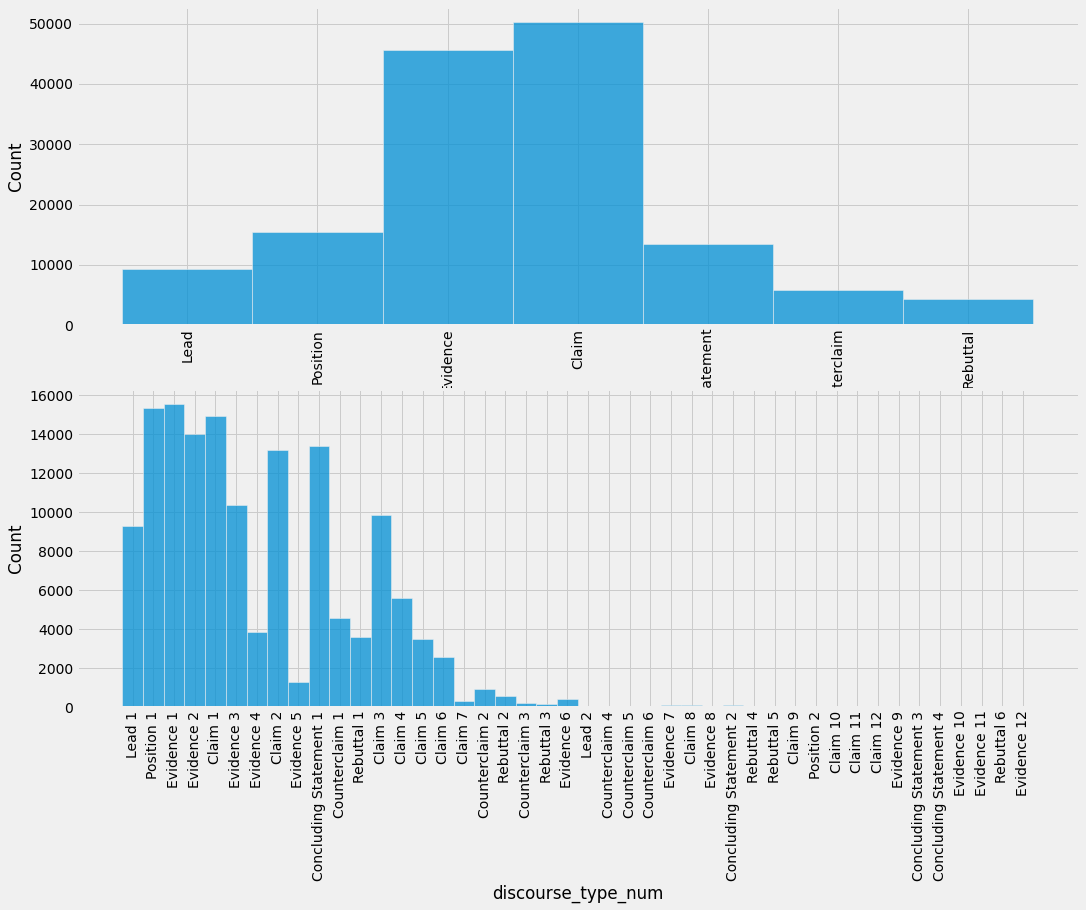

In [4]:
## value counts histograms for discourse_type and discourse_type_num
f, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(16, 12))
sns.histplot( train, x='discourse_type', ax=ax1)
ax1.tick_params(axis='x', rotation=90)
sns.histplot( train, x='discourse_type_num', ax=ax2)
ax2.tick_params(axis='x', rotation=90)

<AxesSubplot:xlabel='discourse_len', ylabel='Count'>

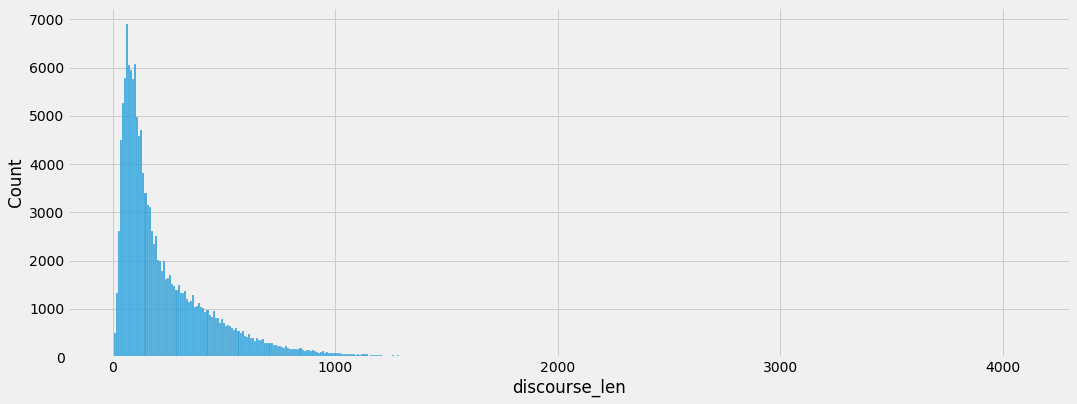

In [5]:
f, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize=(16, 6))
sns.histplot( train, x='discourse_len', ax=ax1)

## Visualizing text

this part based on notebook: https://www.kaggle.com/thedrcat/feedback-prize-eda-with-displacy

tried to implement by hand but this is way better :)

Another great implementation is here: https://www.kaggle.com/robikscube/student-writing-competition-twitch

In [6]:
TYPE_COLORS = {
            'Lead': '#EAE4E9',
            'Position': '#FFF1E6',
            'Evidence': '#CDDAFD',
            'Claim': '#FAD2E1',
            'Concluding Statement': '#E2ECE9',
            'Counterclaim': '#BEE1E6',
            'Rebuttal': '#DFE7FD'
         }

def display_text(text_id):
    ents = []
    for i, row in train[train['id'] == text_id].iterrows():
        ents.append({ 'start': int(row['discourse_start']), 
                      'end': int(row['discourse_end']), 
                      'label': row['discourse_type']
                    })

    with open(TRAIN_PATH + f'{text_id}.txt', 'r') as file: 
        data = file.read()

    doc = { "text": data, "ents": ents, "title": text_id }
    options = {"ents": train.discourse_type.unique().tolist(), "colors": TYPE_COLORS}
    displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)

In [7]:
display_text('423A1CA112E2')

In [8]:
display_text('0000D23A521A')

In [9]:
display_text('008015604AA0')

## Word cloud

In [10]:
def build_text_for_discourse_type(df, discourse_type):
    text = []
    for i, row in df[df['discourse_type'] == discourse_type].iterrows():
        sentence = ' '.join(row['discourse_text'].split())
        text.append(sentence.split())

    temp = [word for sublist in text for word in sublist]
    text = ' '.join(temp)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
        
    return ' '.join(filtered_sentence)

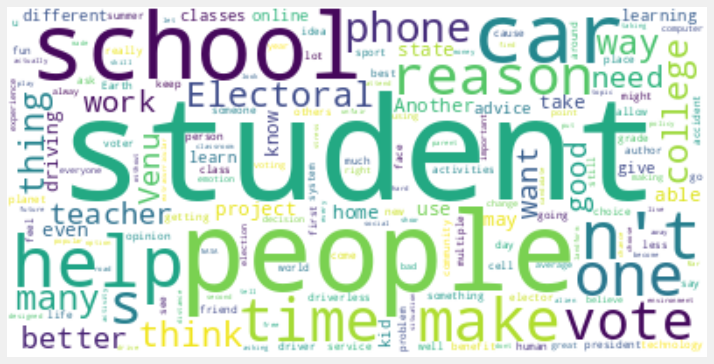

In [11]:
text = build_text_for_discourse_type( train, 'Claim')
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.figure(figsize=(16,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

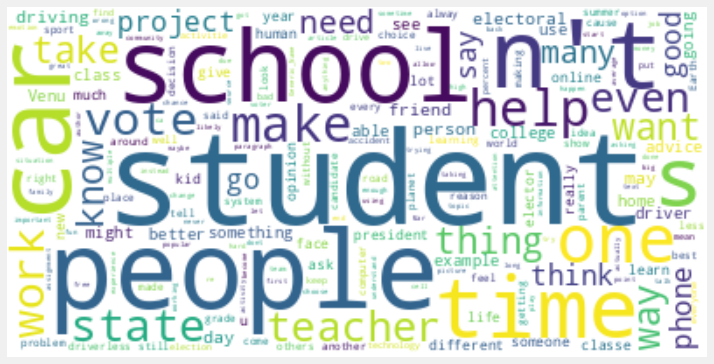

In [12]:
text = build_text_for_discourse_type( train, 'Evidence')
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.figure(figsize=(16,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

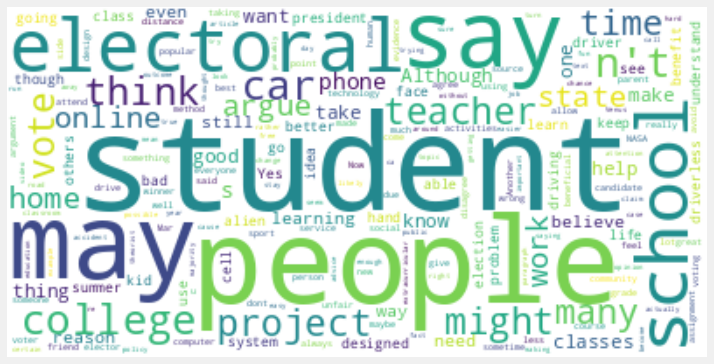

In [13]:
text = build_text_for_discourse_type( train, 'Counterclaim')
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.figure(figsize=(16,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()